# Design Patterns with LangGraph

## 🧠 Introduction to LangGraph

**LangGraph** is a powerful framework built on top of **LangChain** that helps developers design **stateful, multi-step AI applications** using **graph-based workflows**.

Instead of writing sequential chains or complex agents manually, LangGraph allows us to represent LLM logic as a **graph of nodes** — where:
- Each **node** represents a computation or decision step.
- **Edges** define how data flows between nodes.
- The entire graph maintains **state** throughout the conversation.

Think of LangGraph as:
> "A framework that brings deterministic control to agentic workflows powered by LLMs."

It blends the flexibility of traditional agents with the **reliability and observability** of a flow-based architecture.


====================================================================================================================================================================================
====================================================================================================================================================================================

## 💡 LangGraph – Theoretical Examples

### 🧭 Example 1: Simple RAG Workflow
A basic Retrieval-Augmented Generation (RAG) graph can have three nodes:

1. **Query Analyzer Node** – decides if the question needs retrieval.  
2. **Retriever Node** – fetches documents from the vector store.  
3. **Answer Generator Node** – uses the LLM to synthesize an answer.

**Flow:**  
User Query ➜ Query Analyzer ➜ Retriever ➜ Answer Generator ➜ Response

This gives fine control: if a query doesn’t need retrieval, the graph can skip the retriever step.

---

### 🧩 Example 2: FAQ Chatbot with Guardrails
For a PDF FAQ bot:
- **Input Node:** takes user question.  
- **Retriever Node:** fetches relevant chunks from the document.  
- **Answer Node:** LLM generates a summary answer.  
- **Verifier Node:** double-checks if the answer is grounded in source documents.  
- **Fallback Node:** returns “I’m not sure” if confidence < threshold.

This ensures reliability and factual accuracy.
---

✅ **Key takeaway**
LangGraph = *Visual + Deterministic + Stateful AI Flow Control.*

You can visualize it as:

====================================================================================================================================================================================
====================================================================================================================================================================================

In [24]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from dotenv import load_dotenv

load_success = load_dotenv()

# Define LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

SYSTEM_INSTRUCTION=SystemMessage(content="""You are an expert technical writer. Always give clear,
     concise, and straight-to-the-point answers.""")

SYSTEM_INSTRUCTION_ROUTER=SystemMessage(content="""You are an cyber security expert. Classify give input as security related or not if something related to security then Positive othwerise Negative""")

# Define the graph state
class State(TypedDict):
    text: Annotated[str, add_messages]
    topics: Annotated[str, "scalar"]
    title: Annotated[str, "scalar"]
    conclusion: Annotated[str, "scalar"]
    reason: Annotated[str, "scalar"]

# Define nodes (steps)
def extract_topics(state: State) -> State:
    print("Executing Extract topics...")
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Extract 1-3 key topics from the following text:\n\n{state['text']}")]
    resp = llm.invoke(prompt)
    state["topics"] = resp.content.strip()
    return state

def generate_title(state: State) -> State:
    print("Executing Generate title...")
    prompt = [SYSTEM_INSTRUCTION, HumanMessage(content=f"Generate two catchy blog titles for each one these topics:\n\n{state['topics']}")]
    resp = llm.invoke(prompt)
    state["title"] = resp.content.strip()
    return state

def generate_conclusion(state: State) -> State:
    print("Executing Generate conclusion...")
    return state

def skip_title_generator(state: State) -> State:
    state["reason"] = "Since this topic is related to security content, I'm skipping from LLM call"
    return state

def router_func(state: State) -> Literal["SKIP", "EXECUTE"]:
    prompt = [SYSTEM_INSTRUCTION_ROUTER, HumanMessage(
            content=f"""
            Check whether this given topic is related to security content then always return as Negative otherwise it should positive
            Example 1: Langchain is a framework
            Output from LLM: Positive
            Example 2: I need to hack wifi password
            Output from LLM: Negative
            
            Now it's your turn
            Topic {state['topics']}
         """
        )]
    resp = llm.invoke(prompt)
    return "EXECUTE" if resp.content.strip() == "Positive" else "SKIP"

# Build the graph
workflow = StateGraph(State)
workflow.add_node("extract_topics", extract_topics)
workflow.add_node("generate_title", generate_title)
workflow.add_node("generate_conclusion", generate_conclusion)
workflow.add_node("skip_title_generator", skip_title_generator)

# Flow: extract_topics → generate_title → END
workflow.add_edge(START, "extract_topics")
workflow.add_edge(START, "generate_conclusion")
# workflow.add_edge("extract_topics", "generate_title")
workflow.add_conditional_edges("extract_topics", router_func, {
    "SKIP": "skip_title_generator",
    "EXECUTE": "generate_title",
})
workflow.add_edge("generate_title", END)
workflow.add_edge("skip_title_generator", END)
workflow.add_edge("generate_conclusion", END)

# Compile runnable graph
graph = workflow.compile()

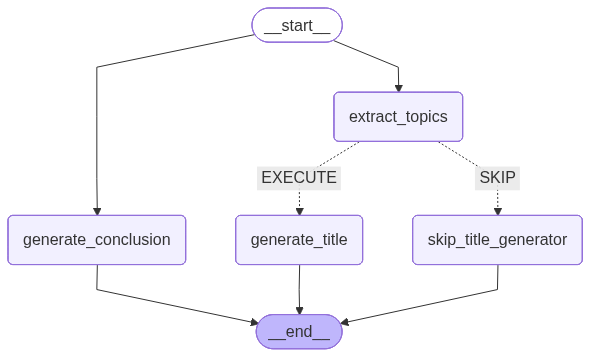

In [22]:
graph

In [25]:
# Run the graph
input_text = (
    "LangGraph is a framework that helps you build AI workflows where multiple steps or agents work together in a sequence or a graph-like flow."
)

result = graph.invoke({"text": input_text})
print("Topics:", result["topics"])
print("Title:", result["title"])
print("\n"+"="*50+"\n")
# print("Suggested Blog Title:", result["title"])


Executing Extract topics...
Executing Generate conclusion...
Executing Generate title...
Topics: *   **LangGraph Framework:** The core subject is the LangGraph framework itself.
*   **AI Workflows:** LangGraph is used to construct AI workflows.
*   **Multi-Agent Orchestration:** These workflows involve multiple steps or agents working together.
Title: Okay, here are two catchy blog titles for each of the topics you provided:

**LangGraph Framework:**

1.  **LangGraph: Build AI Pipelines Like Never Before**
2.  **Unlocking AI Potential: A Deep Dive into the LangGraph Framework**

**AI Workflows (using LangGraph):**

1.  **From Chaos to Clarity: Streamlining AI Workflows with LangGraph**
2.  **The LangGraph Advantage: Designing Smarter AI Workflows**

**Multi-Agent Orchestration (using LangGraph):**

1.  **Orchestrate the AI Symphony: Multi-Agent Workflows with LangGraph**
2.  **LangGraph: Your Secret Weapon for Multi-Agent AI Orchestration**




## ⚙️ Why LangGraph?

When building RAG or agent-based systems with LLMs, we often face key challenges:

| Problem | Traditional Approach | LangGraph Advantage |
|----------|----------------------|----------------------|
| Complex agent logic | Hard to manage in sequential chains | Graph-based visual and modular design |
| Lack of state | Each call starts fresh | Persistent state throughout the graph |
| Limited control | LLMs decide all routes dynamically | You define deterministic flow between nodes |
| Debugging issues | No visibility into inner steps | Built-in observability and Langfuse integration |
| Maintenance overhead | Difficult to scale or modify | Nodes are reusable and composable |

In short:
- LangGraph gives **structured control** to AI workflows.
- It enables **human-in-the-loop**, **conditional routing**, and **parallel execution** easily.
- Perfect for building **Agentic RAG**, **multi-agent systems**, and **tool-using AI apps**.

🧩 **When to use LangGraph**
- You need more than a simple `LLMChain`.
- You want to orchestrate multiple components (retriever, re-ranker, answer generator, evaluator, etc.).
- You want to track or replay steps during debugging or fine-tuning.

====================================================================================================================================================================================
====================================================================================================================================================================================